In [1]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
import matplotlib.pyplot as plt

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
df = pd.read_parquet("/content/drive/MyDrive/CAPSTONE PROJECT/jobs_ML.parquet")
print(df.columns)

Index(['ten_cong_viec', 'link', 'ky_nang_combined', 'nganh_nghe_chuan_hoa'], dtype='object')


In [3]:
X = np.load("/content/drive/MyDrive/CAPSTONE PROJECT/X_all_vector.npy")
df = pd.read_parquet("/content/drive/MyDrive/CAPSTONE PROJECT/jobs_ML.parquet")

# Kiểm tra shape để chắc chắn dữ liệu khớp nhau
print(X.shape, df.shape)

# Lấy nhãn
y = df['nganh_nghe_chuan_hoa']

(9663, 848) (9663, 4)


#Lọc nhãn ngành >= min_samples

In [4]:
min_samples = 80
counts = df['nganh_nghe_chuan_hoa'].value_counts()
valid_labels = counts[counts >= min_samples].index
df_filtered = df[df['nganh_nghe_chuan_hoa'].isin(valid_labels)].reset_index(drop=True)
X_filtered = X[df_filtered.index]
y_filtered = df_filtered['nganh_nghe_chuan_hoa']

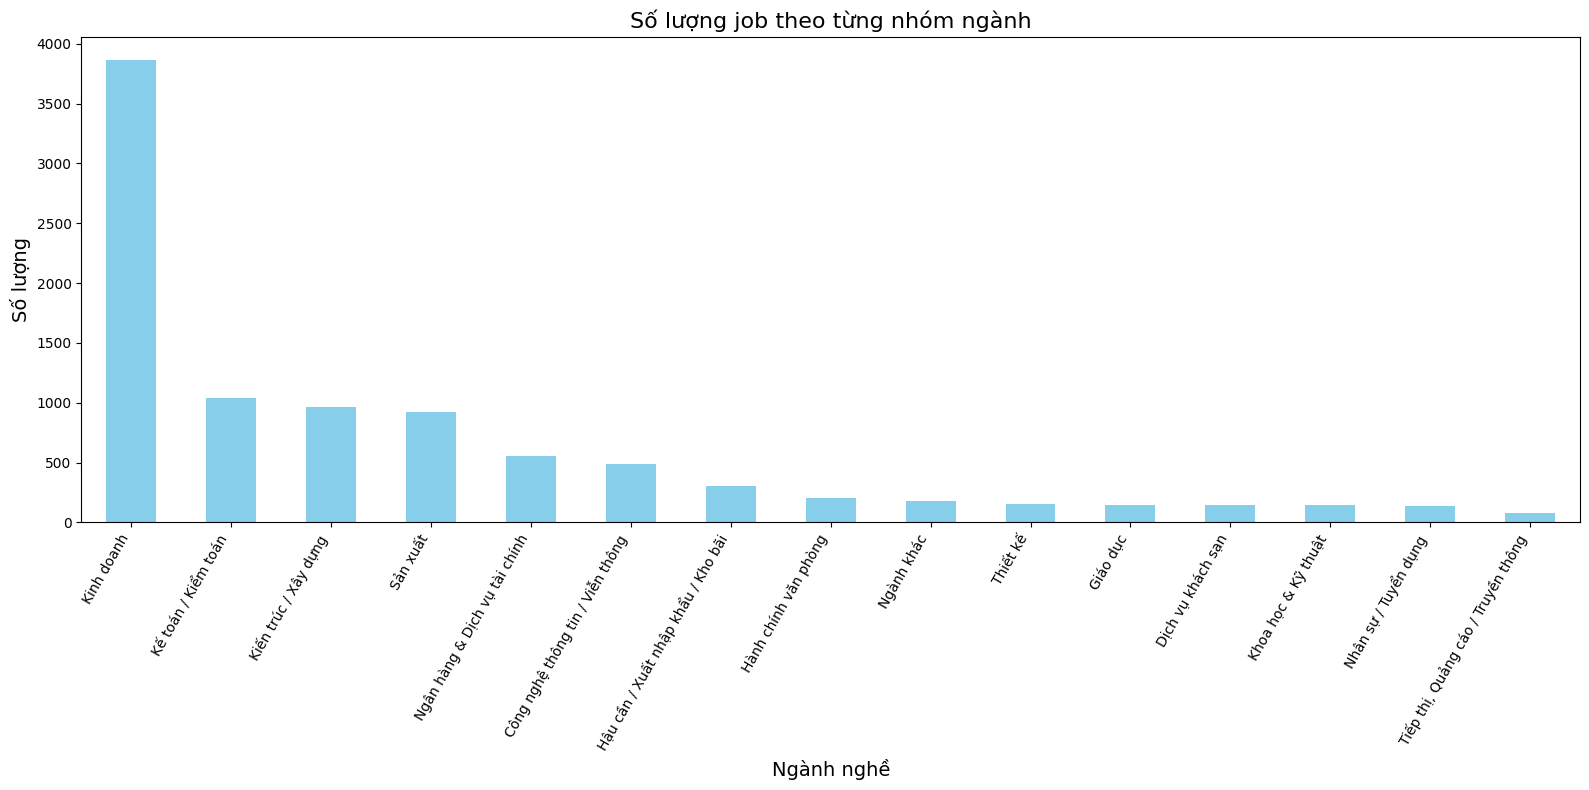

In [5]:
plt.figure(figsize=(16, 8))
df_filtered['nganh_nghe_chuan_hoa'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Số lượng job theo từng nhóm ngành', fontsize=16)
plt.xlabel('Ngành nghề', fontsize=14)
plt.ylabel('Số lượng', fontsize=14)
plt.xticks(rotation=60, ha='right', fontsize=10)
plt.tight_layout()
plt.show()

Điều chỉnh số lượng ngành ít cân bằng lại (oversampling)

In [6]:
print("Trước khi oversampling:", Counter(y_filtered))
ros = RandomOverSampler(random_state=42)
X_over, y_over = ros.fit_resample(X_filtered, y_filtered)
print("Sau khi oversampling:", Counter(y_over))

Trước khi oversampling: Counter({'Kinh doanh': 3865, 'Kế toán / Kiểm toán': 1037, 'Kiến trúc / Xây dựng': 963, 'Sản xuất': 924, 'Ngân hàng & Dịch vụ tài chính': 552, 'Công nghệ thông tin / Viễn thông': 489, 'Hậu cần / Xuất nhập khẩu / Kho bãi': 307, 'Hành chính văn phòng': 203, 'Ngành khác': 177, 'Thiết kế': 155, 'Giáo dục': 150, 'Dịch vụ khách sạn': 148, 'Khoa học & Kỹ thuật': 147, 'Nhân sự / Tuyển dụng': 136, 'Tiếp thị, Quảng cáo / Truyền thông': 82})
Sau khi oversampling: Counter({'Sản xuất': 3865, 'Hậu cần / Xuất nhập khẩu / Kho bãi': 3865, 'Kinh doanh': 3865, 'Ngành khác': 3865, 'Ngân hàng & Dịch vụ tài chính': 3865, 'Khoa học & Kỹ thuật': 3865, 'Kiến trúc / Xây dựng': 3865, 'Kế toán / Kiểm toán': 3865, 'Giáo dục': 3865, 'Công nghệ thông tin / Viễn thông': 3865, 'Thiết kế': 3865, 'Hành chính văn phòng': 3865, 'Nhân sự / Tuyển dụng': 3865, 'Tiếp thị, Quảng cáo / Truyền thông': 3865, 'Dịch vụ khách sạn': 3865})


In [7]:
le = LabelEncoder()
y_over_encoded = le.fit_transform(y_over)
with open("/content/drive/MyDrive/CAPSTONE PROJECT/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

In [8]:
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(
    X_over, y_over_encoded, test_size=0.2, random_state=42, stratify=y_over_encoded
)

In [9]:
model = LogisticRegression(max_iter=500, random_state=42)
model.fit(X_train, y_train_encoded)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test_encoded, y_pred))
print(classification_report(y_test_encoded, y_pred, target_names=le.classes_))

Accuracy: 0.31789564467442866
                                    precision    recall  f1-score   support

  Công nghệ thông tin / Viễn thông       0.33      0.32      0.32       773
                 Dịch vụ khách sạn       0.33      0.42      0.37       773
                          Giáo dục       0.27      0.34      0.30       773
              Hành chính văn phòng       0.34      0.35      0.35       773
Hậu cần / Xuất nhập khẩu / Kho bãi       0.32      0.25      0.28       773
               Khoa học & Kỹ thuật       0.32      0.41      0.36       773
                        Kinh doanh       0.35      0.18      0.23       773
              Kiến trúc / Xây dựng       0.27      0.11      0.16       773
               Kế toán / Kiểm toán       0.34      0.24      0.28       773
                        Ngành khác       0.35      0.43      0.39       773
     Ngân hàng & Dịch vụ tài chính       0.27      0.19      0.22       773
              Nhân sự / Tuyển dụng       0.30      0.40  

#MODEL XGBOOST

In [10]:
!pip install xgboost

In [11]:
import xgboost as xgb
from xgboost import XGBClassifier

model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),  # Số lớp phân loại
    eval_metric='mlogloss',
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

model.fit(X_train, y_train_encoded)

# Dự đoán
y_pred = model.predict(X_test)

# Đánh giá
from sklearn.metrics import classification_report
print(classification_report(
    y_test_encoded,
    y_pred,
    target_names=le.classes_,
    zero_division=1  # để tránh lỗi chia cho 0 nếu có nhãn chưa xuất hiện
))

                                    precision    recall  f1-score   support

  Công nghệ thông tin / Viễn thông       0.93      0.95      0.94       773
                 Dịch vụ khách sạn       0.94      0.98      0.96       773
                          Giáo dục       0.94      1.00      0.97       773
              Hành chính văn phòng       0.93      0.99      0.96       773
Hậu cần / Xuất nhập khẩu / Kho bãi       0.86      0.94      0.90       773
               Khoa học & Kỹ thuật       0.97      0.99      0.98       773
                        Kinh doanh       0.71      0.40      0.51       773
              Kiến trúc / Xây dựng       0.85      0.79      0.82       773
               Kế toán / Kiểm toán       0.82      0.77      0.79       773
                        Ngành khác       0.94      1.00      0.97       773
     Ngân hàng & Dịch vụ tài chính       0.84      0.90      0.87       773
              Nhân sự / Tuyển dụng       0.96      1.00      0.98       773
           

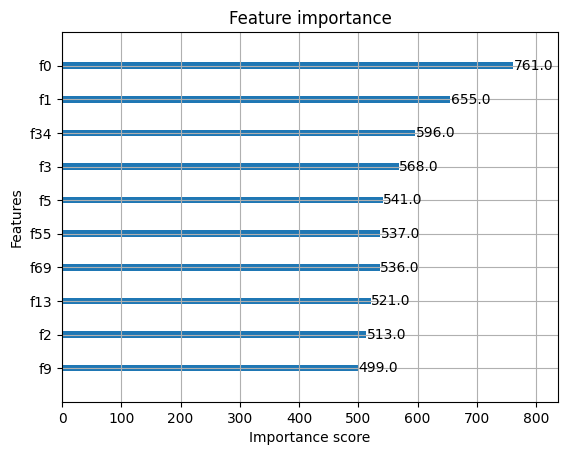

In [12]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=10)
plt.show()

#MODEL RANDOMFOREST

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Khởi tạo mô hình Random Forest
rf_model = RandomForestClassifier(
    n_estimators=150,           # Số lượng cây
    class_weight='balanced',    # Cân bằng trọng số các lớp
    random_state=42,
    n_jobs=-1                   # Sử dụng tối đa CPU cho train
)

# Huấn luyện mô hình
rf_model.fit(X_train, y_train_encoded)

# Dự đoán trên tập test
y_pred_rf = rf_model.predict(X_test)

# Đánh giá mô hình
print("Accuracy:", accuracy_score(y_test_encoded, y_pred_rf))
print(classification_report(
    y_test_encoded, y_pred_rf,
    target_names=le.classes_,
    zero_division=1
))

Accuracy: 0.9657611039241052
                                    precision    recall  f1-score   support

  Công nghệ thông tin / Viễn thông       0.97      0.97      0.97       773
                 Dịch vụ khách sạn       0.96      0.99      0.97       773
                          Giáo dục       0.97      1.00      0.99       773
              Hành chính văn phòng       0.97      0.99      0.98       773
Hậu cần / Xuất nhập khẩu / Kho bãi       0.97      0.97      0.97       773
               Khoa học & Kỹ thuật       0.99      0.99      0.99       773
                        Kinh doanh       0.90      0.86      0.88       773
              Kiến trúc / Xây dựng       0.97      0.93      0.95       773
               Kế toán / Kiểm toán       0.97      0.92      0.94       773
                        Ngành khác       0.97      1.00      0.98       773
     Ngân hàng & Dịch vụ tài chính       0.95      0.97      0.96       773
              Nhân sự / Tuyển dụng       0.99      1.00   

#MODEL LIGHTGBM

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report

lgbm_model = LGBMClassifier(
    objective='multiclass',
    num_class=len(le.classes_),      # Số lớp phân loại - đã fit bởi LabelEncoder
    boosting_type='gbdt',
    learning_rate=0.1,
    n_estimators=100,
    max_depth=6,
    random_state=42,
    n_jobs=-1,                      # Sử dụng đa lõi CPU
    class_weight='balanced'         # Tự động cân bằng lớp nếu có
)

lgbm_model.fit(X_train, y_train_encoded)
y_pred_lgbm = lgbm_model.predict(X_test)

print("Accuracy LightGBM:", accuracy_score(y_test_encoded, y_pred_lgbm))
print(classification_report(
    y_test_encoded, y_pred_lgbm,
    target_names=le.classes_,
    zero_division=1
))

In [ ]:
import joblib

# Lưu mô hình Random Forest hoặc model tốt nhất
joblib.dump(rf_model, "/content/drive/MyDrive/CAPSTONE PROJECT/random_forest_model.pkl")

joblib.dump(model, "/content/drive/MyDrive/CAPSTONE PROJECT/xgb_model.pkl")  # nếu dùng XGBoost
joblib.dump(lgbm_model, "/content/drive/MyDrive/CAPSTONE PROJECT/lgbm_model.pkl")  # nếu dùng LightGBM
